## What is Fine tuning

Fine-tuning in machine learning is the process of adapting a pre-trained model for specific tasks or use cases. It has become a fundamental deep learning technique, particularly in the training process of foundation models used for generative AI.

— From ibm.com

## Fine-Tuning an LLM for Child-Safe Comment Analysis
#============================================================================================#


The primary purpose of this project is to fine-tune an LLM model to safeguard children by filtering inappropriate content from comments on children's videos. 
It functions as a digital guardian, analyzing text within comments to determine if they align with standards of appropriateness for young audiences.

By identifying and flagging comments containing harmful, offensive, or unsuitable language, the model helps create a safer online environment for children.

### Step 1 - Setting up project Environment

##### Importing modules

In [7]:
from openai import OpenAI
import pandas as pd
import json
import time
import matplotlib.pyplot as plt

##### Setup OpenAI API Keys

In [6]:
api_key = "<OpenAI API Key>"

##### Create OpenAI Client

In [8]:
openai = OpenAI(api_key=api_key)
openai

### Step 2 - Data preparation

##### Get training data

In [29]:
training_data = pd.read_csv("users-comments.csv")
training_data.head()

,user_id,comment,date,label
0,1,This video is so funny!,2023-11-22,allow
1,2,I love the puppy! Can we have one?,2023-11-23,allow
2,3,This game is stupid! The creator is a loser.,2023-11-24,disallow
3,4,The colors are so pretty!,2023-11-25,allow
4,5,You're ugly and dumb.,2023-11-26,disallow


##### Convert data into acceptable format

In [30]:
{
    "messages": [
        {"role": "system", "content": "<The system prompt>"},
        {"role": "user", "content": "<The user prompt>"},
        {"role": "assistant", "content": "<The required/correct response>"}
    ]
},

({'messages': [{'role': 'system', 'content': '<The system prompt>'},
   {'role': 'user', 'content': '<The user prompt>'},
   {'role': 'assistant', 'content': '<The required/correct response>'}]},)

Create a system prompt

In [11]:
system_prompt = """
    Given a user comment on children videos, 
    check if the comment is appropriate for children 
    and determines if the comment should be allowed or 
    disallowed for children to view.
    Return a single word in the following format:
    - 'allow' if the comment is safe for children
    - 'disallow' if the comment is not safe for children
    """

Extract each user's comment and the label from our training data, and convert each row to match the accepted format. Finally we'll store the results in a json file.

In [33]:
output_file = "training_data.json"
for index, row in training_data.iterrows():
    json_data = {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": row.comment},
            {"role": "assistant", "content": row.label}
        ]
    }
    # Write data into a json file
    with open(output_file, "a") as f:
        json.dump(json_data, f)
        f.write("\n")

{'messages': [{'role': 'system', 'content': "\n    Given a user comment on children videos, check if the comment is appropriate for children \n    and determines if the comment should be allowed or disallowed for children to view.\n    Return a single word in the following format:\n    - 'allow' if the comment is safe for children\n    - 'disallow' if the comment is not safe for children\n    "}, {'role': 'user', 'content': 'This video is so funny!'}, {'role': 'assistant', 'content': 'allow'}]}
{'messages': [{'role': 'system', 'content': "\n    Given a user comment on children videos, check if the comment is appropriate for children \n    and determines if the comment should be allowed or disallowed for children to view.\n    Return a single word in the following format:\n    - 'allow' if the comment is safe for children\n    - 'disallow' if the comment is not safe for children\n    "}, {'role': 'user', 'content': 'I love the puppy! Can we have one?'}, {'role': 'assistant', 'content': 

### Step 3 - Fine-tune LLM model

Upload our training data to openai

In [9]:
training_file = openai.files.create(
    file=open(output_file, "rb"),
    purpose="fine-tune"
)
training_file

FileObject(id='file-IGyWUengGUs1QTozNVhXI1X6', bytes=208669, created_at=1723690424, filename='train_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

Create a fine-tuning job

In [10]:
job = openai.fine_tuning.jobs.create(
    training_file=training_file.id,
    model="gpt-3.5-turbo",
    hyperparameters={
        # "n_epochs":'auto', # The number of full cycle through the training dataset.
        # "batch_size": 16, # Number of examples in each batch
        # "learning_rate": 0.01, #Scaling factor for the learning rate
    }
)
job

FineTuningJob(id='ftjob-i5G40bUH9pE2gaNtJiJQXnbK', created_at=1723690443, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-CnqoU6Ywmq6IZD3QDf7aGQ1o', result_files=[], seed=2020475909, status='validating_files', trained_tokens=None, training_file='file-IGyWUengGUs1QTozNVhXI1X6', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

Check the status of the job

In [11]:
print("Waiting ...")
while True:
    running_job = openai.fine_tuning.jobs.retrieve(job.id)
    if running_job.status == "succeeded":
        print("Job succeeded!")
        break
    elif running_job.status == "failed" or running_job.status == "cancelled":
        print("Job failed!")
        break
    time.sleep(100)

Waiting ...
Job succeeded!


### Step 4 - Analyse model

A well trained model should have:
1. Taining loss decreasing in each step and
2. Token accuracy increasing.

In [9]:
events = openai.fine_tuning.jobs.list_events(
    fine_tuning_job_id=job.id,
    limit=100,
)
events_list = list(events.data)
for index, event in enumerate(events_list):
    if index >= 10: break
    print(event)

FineTuningJobEvent(id='ftevent-HyhduE5rPjoToDONZ0TPF4og', created_at=1723692884, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-1sXeZ3b0SY7IrBgHQ0eb1z1h', created_at=1723692884, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-yHkvSXsA3FD5LB3dXkXffOgu', created_at=1723692872, level='info', message='New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9wLXscQL', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-ZalszLyCtZqvDQ7ShVbdgN5r', created_at=1723692872, level='info', message='Checkpoint created at step 806 with Snapshot ID: ft:gpt-3.5-turbo-0125:personal::9wLXrxxN:ckpt-step-806', object='fine_tuning.job.event', data={}, type='message')
FineTuningJobEvent(id='ftevent-tUGxEeNz9qdER0Fb6zmkJZeo', created_at=1723692872, level='info', message=

Extract training loss and accuracy

In [25]:
steps = []
train_loss = []
train_mean_accuracy = []
for index, event in enumerate(events_list):
    # if index >= 100: break
    if event.data:
        steps.append(event.data['step'])
        train_loss.append(event.data['train_loss'])
        train_mean_accuracy.append(event.data['train_mean_token_accuracy'])
print(steps)
print(train_loss)
print(train_mean_accuracy)

[1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209]
[4.76837158203125e-07, 6.35782896551973e-07, 4.76837158203125e-07, 6.35782896551973e-07, 6.35782896551973e-07, 4.76837158203125e-07, 6.35782896551973e-07, 4.76837158203125e-07, 6.35782896551973e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 4.76837158203125e-07, 6.35782896551973e-07, 4.76837158203125e-07, 6.35782896551973e-07, 6.35782896551973e-07, 6.35782896551973e-07, 4.76837158203125e-07, 6.35782896

Plot a line graph to see how training loss changes in each step. 

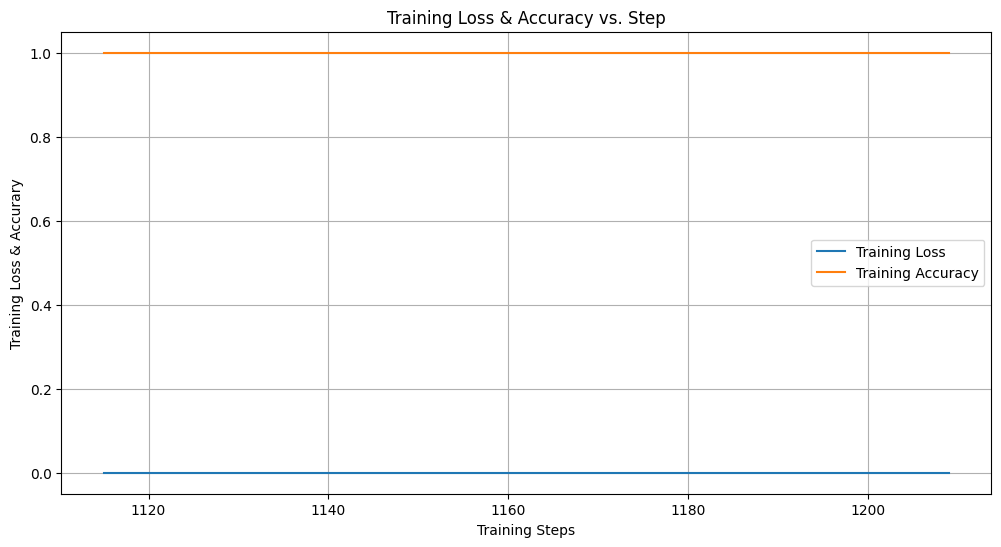

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, train_mean_accuracy, label='Training Accuracy')

plt.xlabel('Training Steps')
plt.ylabel('Training Loss & Accurary')
plt.title('Training Loss & Accuracy vs. Step')

plt.legend()
plt.grid(True)
plt.show()

### Step 5 - Use model

Extract the trained model Id

In [21]:
trained_model = running_job.fine_tuned_model
trained_model

'ft:gpt-3.5-turbo-0125:personal::9wLXscQL'

A function that useses the fine-tuned model to analyse user comments

In [17]:
def check_comment(comment, model) -> str: # allow or disallow
    # Get ai response
    response = openai.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": comment}
        ]
    )
    response = response.choices[0].message.content
    return response

use your model

In [18]:
comment = "I love this video"
print(check_comment(comment, trained_model))

allow


Compare your trained model with other models

In [19]:
comment = "I hate you."
print(check_comment(comment, trained_model))
print(check_comment(comment, "gpt-3.5-turbo"))
print(check_comment(comment, "gpt-4"))

disallow
disallow
disallow
